I also tried to combine both taking previous months and the values coming from the same month on the previous years but that did not also gave really good result. (I did not create 12 different models but one model overall.)

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import os

# This is the data preparation Part I explained this in the 'drawingGraph.ipynb' file
data =  pd.read_csv("monatszahlen2209_verkehrsunfaelle.csv")
data = data.iloc[:, :5] 
data.rename(columns={'MONATSZAHL': 'category'
                  , 'AUSPRÄGUNG': 'accidentType'
                  , 'JAHR': 'year'
                  , 'MONAT': 'month'
                  , 'WERT': 'value'}, inplace=True)
data = data[data["month"].str.lower() != "summe"]
data = data[data['accidentType'] == 'insgesamt']
data = data[data['category'] == 'Alkoholunfälle']
data['month'] = data['month'].apply(lambda x: int(str(x)[-2:]) if str(x).isdigit() else x)
data['Date'] = pd.to_datetime(data[['year', 'month']].assign(day=1)) #[day] is missing error was shown so I put the first day for each date 
toBeUsedForTesting = data #I will use this later for testing
data = data[data['year'] <= 2020].reset_index(drop=True) #because we will make predictions for 2021

In [3]:
# This is the model creation part I am using LSTM again
# Like the previous model I used dropout the prevent overfitting 
def create_model():
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, 5)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [4]:
# This is again like the previous model I am creating the previous steps and the 
# value that will be made predictions about
def dataset_creation(data, pre_steps):
    X, Y = [], []
    for i in range(len(data)-pre_steps-1):
        X.append(data[i:(i+pre_steps)])
        Y.append(data[i + pre_steps])
    return np.array(X), np.array(Y)

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1)) # Creating a MinMaxScaler object
data.sort_values(by="Date", inplace=True) # Sort the dataframe by 'Date'
data_values = data['value'].values.reshape(-1, 1) # reshaping values to be a 2D array which is required for the scaler
data_values_scaled = scaler.fit_transform(data_values) # Fit the scaler to the data and transform the data in a single step.
past_months = 5 # the number of previous months

trainX, trainY = dataset_creation(data_values_scaled, past_months) # Generate the past data
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1])) # Reshape the input 

model = create_model() # Creating the LSTM model using the defined function.
model.fit(trainX, trainY, epochs=50, batch_size=4, verbose=2) # Training the model 

model.save(f"models\model3/model.h5") # Save the model 
joblib.dump(scaler, f'models\model3/scaler.pkl') # Save the scaler to a file for later use.

Epoch 1/50
62/62 - 5s - loss: 0.1325 - 5s/epoch - 85ms/step
Epoch 2/50
62/62 - 0s - loss: 0.1068 - 198ms/epoch - 3ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0977 - 206ms/epoch - 3ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0988 - 264ms/epoch - 4ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0929 - 237ms/epoch - 4ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0897 - 204ms/epoch - 3ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0880 - 215ms/epoch - 3ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0820 - 197ms/epoch - 3ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0774 - 178ms/epoch - 3ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0755 - 141ms/epoch - 2ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0761 - 166ms/epoch - 3ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0719 - 198ms/epoch - 3ms/step
Epoch 13/50
62/62 - 0s - loss: 0.0728 - 242ms/epoch - 4ms/step
Epoch 14/50
62/62 - 0s - loss: 0.0701 - 287ms/epoch - 5ms/step
Epoch 15/50
62/62 - 0s - loss: 0.0694 - 271ms/epoch - 4ms/step
Epoch 16/50
62/62 - 0s - loss: 0.0697 - 266ms/epoch - 4ms/step
Epo

['models\\model3/scaler.pkl']

In [6]:
def predict_accidents(year, month):
    data_to_predict = data[(data['year'] < year) & (data['month'] == month)]['value'].values[-past_months:] # Extracting the required data for prediction.
    data_to_predict_scaled = scaler.transform(data_to_predict.reshape(-1, 1)) # Scaling the data
    data_to_predict_scaled = data_to_predict_scaled.reshape((1, 1, past_months)) # Reshaping the data 
    prediction = model.predict(data_to_predict_scaled) # Make a prediction using the trained model.
    prediction = scaler.inverse_transform(prediction) # Rescale the prediction to the original scale.
    return prediction # Return the prediction.

In [7]:
prediction = predict_accidents(2021, 1) # Predict the number of accidents for January 2021.
print(f"Predicted number : {prediction}")

1/1 [==============================] - 1s 789ms/step
Predicted number : [[32.742863]]


1/1 [==============================] - 0s 47ms/step


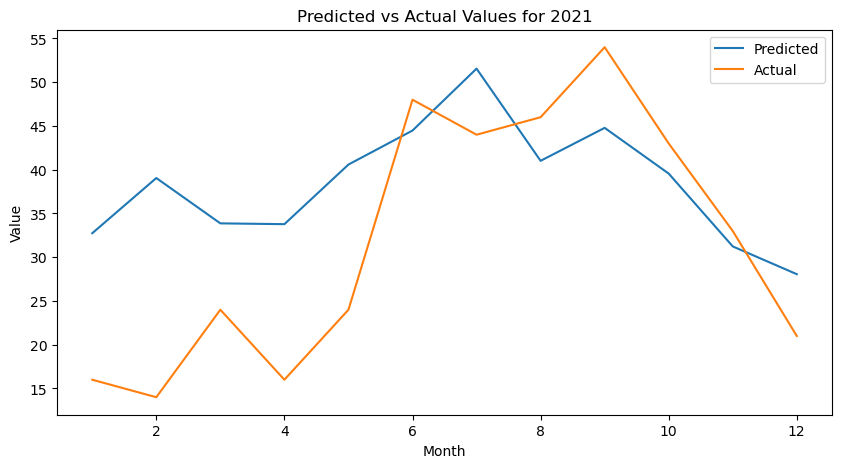

In [8]:
predictions = {}
actuals = {}

# Predicting the values for each month in 2021
for month in range(1, 13):
    prediction = predict_accidents(2021, month)
    actual = toBeUsedForTesting[(toBeUsedForTesting['Date'].dt.year == 2021) & (toBeUsedForTesting['Date'].dt.month == month)]['value'].values[0]
    predictions[month] = prediction.flatten()[0]  # flatten the prediction and take the first value
    actuals[month] = actual

# Plotting the predicted vs actual values for 2021
plt.figure(figsize=(10, 5))
plt.plot(list(predictions.keys()), list(predictions.values()), label='Predicted')
plt.plot(list(actuals.keys()), list(actuals.values()), label='Actual')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values for 2021')
plt.legend()
plt.show()

In [9]:
# predictions ve actuals dictionaries to Dataframes
df_predictions = pd.DataFrame(list(predictions.values()), columns=['Predictions'], index=list(predictions.keys()))
df_actuals = pd.DataFrame(list(actuals.values()), columns=['Actuals'], index=list(actuals.keys()))

# df and real values 
df = pd.concat([df_predictions, df_actuals], axis=1)

# put these values to predictions to compare them later
df.to_csv('predictions/3prediction.csv')
